In [ ]:
import torch
import torch.nn as nn

## I.Data:

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/masteno/lines_classification/main/pipe_helper.py'
response = requests.get(url)
with open('pipe_helper2.py', 'wb') as f:
    f.write(response.content)

In [ ]:
mkdir MFlya_oii_220w

In [ ]:
mkdir UDFlya_oii_220w

In [ ]:
from pipe_helper2 import *
#mixed data:
mf = read_data('MFlya_oii_220w/')
udf = read_data('UDFlya_oii_220w/')

train_loader, test_loader = udf.split_data(combine=True, B=mf,max_norm=True,random_seed=42,TEST_SIZE=0.1,VAL_SIZE=0, BATCH_SIZE=5)


****
Length of train dataloader: 646 batches of 5
Length of test dataloader: 72 batches of 5


## II. Architecture and model:


In [ ]:
import torch
from torch import nn
#from .util import calc_normalization
class MLP(nn.Sequential):
    """ #####  Multi-Layer Perceptron:
    A simple implementation with a configurable number of hidden layers and
    activation functions.
    Parameters
    ----------
    n_in: int --> Input dimension
    n_out: int --> Output dimension
    n_hidden: list of int --> Dimensions for every hidden layer
    act: list of callables
        --> Activation functions after every layer. Needs to have len(n_hidden) + 1
            If `None`, will be set to `LeakyReLU` for every layer.
    dropout: float --> Dropout probability
    """

    def __init__(self, n_in, n_out, n_hidden=(16, 16, 16), act=None, dropout=0):
        if act is None:
            act = [ nn.LeakyReLU(),] * (len(n_hidden) + 1)
        assert len(act) == len(n_hidden) + 1

        layer = []
        n_ = [n_in, *n_hidden, n_out]
        for i in range(len(n_) - 1):
            layer.append(nn.Linear(n_[i], n_[i + 1]))
            layer.append(act[i])
            layer.append(nn.Dropout(p=dropout))

        super(MLP, self).__init__(*layer)

In [ ]:
class SpeculatorActivation(nn.Module):
    """Activation function from the Speculator paper
    .. math:
        a(\mathbf{x}) = \left[\boldsymbol{\gamma} + (1+e^{-\boldsymbol\beta\odot\mathbf{x}})^{-1}(1-\boldsymbol{\gamma})\right]\odot\mathbf{x}
    Paper: Alsing et al., 2020, ApJS, 249, 5
    Parameters
    ----------
    n_parameter: int --> Number of parameters for the activation function to act on
    plus_one: bool --> Whether to add 1 to the output
    """

    def __init__(self, n_parameter, plus_one=False):
        super().__init__()
        self.plus_one = plus_one
        self.beta = nn.Parameter(torch.randn(n_parameter), requires_grad=True)
        self.gamma = nn.Parameter(torch.randn(n_parameter), requires_grad=True)

    def forward(self, x):
        """Forward method
        Parameters
        ----------
        x: `torch.tensor`
        Returns
        -------
        x': `torch.tensor`, same shape as `x`
        """
        # eq 8 in Alsing+2020
        x = (self.gamma + (1 - self.gamma) * torch.sigmoid(self.beta * x)) * x
        if self.plus_one:
            return x + 1
        return x

In [ ]:
class LineEncoder(nn.Module):
    """Line encoder:
    Modified version of the encoder by Serrà et al. (2018), which combines a 3 layer CNN
    with a dot-product attention module. This encoder adds a MLP to further compress the
    attended values into a low-dimensional latent space.
    Paper: Serrà et al., https://arxiv.org/abs/1805.03908

    Parameters
    ----------
    n_latent: int --> Dimension of latent space
    n_hidden: list of int --> Dimensions for every hidden layer of the :class:`MLP`
    act: list of callables
        Activation functions after every layer. Needs to have len(n_hidden) + 1
        If `None`, will be set to `LeakyReLU` for every layer.
    dropout: float
        Dropout probability
    """

    def __init__(self, instrument, n_latent, n_hidden=(128, 64, 32), act=None, dropout=0):
        super(LineEncoder, self).__init__()
        self.instrument = instrument
        self.n_latent = n_latent # latent vect dim
        filters = [64, 128, 256] # number of filters for each conv block
        sizes = [3, 3, 3] # size of each filter
        self.conv1, self.conv2, self.conv3 = self._conv_blocks(filters, sizes, dropout=dropout)
        self.n_feature = filters[-1] *55#// 2

        # pools and softmax work for spectra and weights
        #self.pool1, self.pool2 = tuple( nn.MaxPool1d(s, padding= s // 2) for s in sizes[:2])
        self.pool1, self.pool2 = nn.MaxPool1d(2,2), nn.MaxPool1d(2,2)
        self.softmax = nn.Softmax(dim=-1)

        # small MLP to go from CNN features to latents
        if act is None:
            act = [nn.PReLU(n) for n in n_hidden]
            # last activation identity to have latents centered around 0
            act.append(nn.Identity())
        self.mlp = MLP(self.n_feature, self.n_latent, n_hidden=n_hidden, act=act, dropout=dropout)

    def _conv_blocks(self, filters, sizes, dropout=0):
        convs = []
        for i in range(len(filters)):
            f_in = 1 if i == 0 else filters[i - 1]
            f = filters[i]
            s = sizes[i]
            p = s // 2
            conv = nn.Conv1d( in_channels=f_in, out_channels=f, kernel_size=s, padding=p,)
            norm = nn.InstanceNorm1d(f)
            act = nn.PReLU(f)
            drop = nn.Dropout(p=dropout)
            convs.append(nn.Sequential(conv, norm, act, drop))
        return tuple(convs)

    def _downsample(self, x):
        # compression
        #x = x.unsqueeze(1)
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.conv3(x) # shape: [B, number of filters, 220]
        #C = x.shape[1] // 2
        # split half channels into attention value and key
        #h, a = torch.split(x, [C, C], dim=1)

        #return h, a
        return x

    def forward(self, y):
        """Forward method
        Parameters
        ----------
        y: `torch.tensor`, shape (N, L)
            Batch of observed spectra
        Returns
        -------
        s: `torch.tensor`, shape (N, n_latent)
            Batch of latents that encode `spectra`
        """
        #with self attention:#########
        # run through CNNs
        #h, a = self._downsample(y)
        # softmax attention
        #a = self.softmax(a)
        # attach hook to extract backward gradient of a scalar prediction
        # for Grad-FAM (Feature Activation Map)
        #if ~self.training and a.requires_grad == True:
        #    a.register_hook(self._attention_hook)
        # apply attention
        #x = torch.sum(h * a, dim=2)
        # run attended features into MLP for final latents
        #x = self.mlp(x)

        #without self attention:########
        x = self._downsample(y)
        x = torch.flatten(x, start_dim=1)
        x = self.mlp(x)
        #x = self.mlp(x)
        return x

    @property
    def n_parameters(self):
        """Number of parameters in this model"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def _attention_hook(self, grad):
        self._attention_grad = grad

    @property
    def attention_grad(self):
        """Gradient of the attention weights

        Factor to compute the importance of attention for Grad-FAM method.

        Requires a previous `loss.backward` call for any scalar loss function based on
        outputs of this class's `forward` method. This functionality is switched off
        during training.
        """
        if hasattr(self, "_attention_grad"):
            return self._attention_grad
        else:
            return None

In [ ]:
class LineDecoder(nn.Module):
    """Spectrum decoder
    Simple :class:`MLP` to create a restframe spectrum from a latent vector,
    followed by explicit redshifting, resampling, and convolution transformations to
    match the observations from a given instrument.

    Parameter
    ---------
    wave_rest: `torch.tensor` --> Restframe wavelengths
    n_latent: int -->Dimension of latent space
    n_hidden: list of int
        Dimensions for every hidden layer of the :class:`MLP`
    act: list of callables
        Activation functions after every layer. Needs to have len(n_hidden) + 1
        If `None`, will be set to :class:`SpeculatorActivation` for every layer.
    dropout: float
        Dropout probability
    """

    def __init__( self,width, up_width, n_latent=5, n_hidden=(64, 256, 512), act=None, dropout=0,):

        super(LineDecoder, self).__init__()
        if act is None:
            act = [SpeculatorActivation(n) for n in n_hidden]
            act.append(SpeculatorActivation(up_width, plus_one=False))

        self.mlp = MLP( n_latent,up_width , n_hidden=n_hidden, act=act, dropout=dropout,)
        self.n_latent = n_latent
        self.w = width


    def decode(self, s):
        """Decode latents into restframe spectrum
        Parameter
        ---------
        s: `torch.tensor`, shape (N, S)
            Batch of latents
        Returns
        -------
        x: `torch.tensor`, shape (N, L)
            Batch of restframe spectra
        """
        return self.mlp.forward(s)

    def forward(self, s,lbda, instrument=None):
        """Forward method
        Parameter
        ---------
        s: `torch.tensor`, shape (N, S)
            Batch of latents
        instrument: :class:`spender.Instrument`
            Instrument to generate spectrum for
        Returns
        -------
        y: `torch.tensor`, shape (N, L)
            Batch of spectra at redshift `z` as observed by `instrument`
        """
        # restframe
        Line = self.decode(s)
        # observed frame
        if instrument is not None :
            Line = self.transform(Line,lbda, instrument=instrument)
        return Line

    def transform(self, x,lbda, instrument=None):
        """Transformations from supe-resolution to observed frame
        Parameter
        ---------
        x: `torch.tensor`, shape (N, S)
            Batch of restframe Lines
        instrument: :class:`spender.Instrument`
            Instrument to generate spectrum for

        Returns
        -------
        y: `torch.tensor`, shape (N, L)
            Batch of spectra at redshift `z` as observed by `instrument`
        """
        # down sample to input line width:
        Line = F.interpolate(x.unsqueeze(dim=1), size= self.w, mode='linear', align_corners=False)
        #print(Line.shape)
        # convolve with LSF
        if instrument.lsf is not None:
            Line = instrument.lsf(Line, lbda)#.squeeze(1)

        return Line

    @property
    def n_parameters(self):
        """Number of parameters in this model"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
class BaseAutoencoder(nn.Module):
    """Base class for spectrum autoencoder
    This class is agnostic about the encoder and decoder architectures. It simply calls
    them in order and computes the loss for the recontruction fidelity.
    The only requirements for the modules is that they have the same latent
    dimensionality, and for the `loss` method the length of the observed spectrum
    vectors need to agree.
    Parameter
    ---------
    encoder: `nn.Module`
        Encoder
    decoder: `nn.Module`
        Decoderimport torch.optim as optim
    """

    def __init__(self, encoder, decoder,):
        super(BaseAutoencoder, self).__init__()
        assert encoder.n_latent == decoder.n_latent
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x):
        """Encode from observed Lines to latents
        Parameters
        ----------
        y: `torch.tensor`, shape (N, L)
            Batch of observed spectra
        Returns
        -------
        s: `torch.tensor`, shape (N, n_latent)
            Batch of latents that encode `spectra`
        """
        return self.encoder(x)

    def decode(self, s):
        """Decode latents into super resolution line
        Parameter
        ---------
        s: `torch.tensor`, shape (N, S)
            Batch of latents
        Returns
        -------
        x: `torch.tensor`, shape (N, L)
            Batch of super resolution lines
        """
        return self.decoder(s, None)

    def _forward(self, y,lbda, instrument=None, z=None, s=None, normalize=False, weights=None):
        """Perform a forward pass through the model to create a latent, super-resol, and reconstruction from an observed line, instrument.
         If inverse variance weights are passed,
         also normalizes the reconstruction to the observed spectrum."""
        if s is None:
            s = self.encode(y)
        if instrument is None:
            instrument = self.encoder.instrument
        # make super-resol model line
        restframe = self.decode(s).squeeze(dim=0)
        # make resampled and interpolated reconstruction
        reconstruction = self.decoder.transform(restframe,lbda, instrument=instrument)
        # normalize restframe and reconstruction to observed spectrum
        if normalize:
            if weights is None: # vmap requires tensors
                weights = torch.ones_like(y)
            restframe, reconstruction = torch.vmap(self.normalize)( y, weights, restframe, reconstruction)
        return s, restframe, reconstruction

    def forward(self, y,lbda, instrument=None, z=None, s=None, normalize=False, weights=None):
        """Forward method
        Transforms observed spectra into their reconstruction for a given intrument and redshift.
        If weights are passed, also normalizes the reconstruction to the observed spectrum.

        Parameter
        ---------
        y: `torch.tensor`, shape (N, L)
            Batch of observed spectra
        instrument: :class:`spender.Instrument`
            Instrument to generate spectrum for
        z: `torch.tensor`, shape (N, 1)
            Redshifts for each spectrum. When given, `aux` is ignored.
        s: `torch.tensor`, shape (N, S)
            (optional) Batch of latents. When given, encoding is omitted and these latents are used instead.
        normalize: bool
            (optional) Whether to normalize the reconstruction match the amplitude of the observed spectrum.
            If this is set to False, it requires that the spectra have been flux-normalized.
        weights: `torch.tensor`, shape (N, L)
            (optional) Inverse variance weights for each spectrum, used for normalization computation.

        Returns
        -------
        y: `torch.tensor`, shape (N, L)
            Batch of spectra at redshift `z` as observed by `instrument`
        """
        s, x, y_ = self._forward(y,lbda, instrument=instrument, z=z, s=s, normalize=normalize, weights=weights)

        return s,x,y_

    def loss(self, y,lbda, weights, instrument=None, z=None, s=None, normalize=False, individual=False):
        """ Weighted MSE loss
        Parameter
        --------
        y: `torch.tensor`, shape (N, L)
            Batch of observed spectra
        weights: `torch.tensor`, shape (N, L)
            Batch of weights for observed spectra
        instrument: :class:`spender.Instrument`
            Instrument to generate spectrum for
        z: `torch.tensor`, shape (N, 1)
            Redshifts for each spectrum. When given, `aux` is ignored.
        s: `torch.tensor`, shape (N, S)
            (optional) Batch of latents. When given, encoding is omitted and these
            latents are used instead.
        normalize: bool
            (optional) Whether to normalize the reconstruction match the amplitude of the observed spectrum.
            If this is set to False, it requires that the spectra have been flux-normalized.
        individual: bool
            Whether the loss is computed for each spectrum individually or aggregated

        Returns
        -------
        float or `torch.tensor`, shape (N,) of weighted MSE loss
        """
        _,__,y_ = self.forward(y,lbda, instrument=instrument, z=z, s=s, normalize=normalize)
        return self._loss(y, weights, y_, individual=individual)

    def _loss(self, y, weights, y_, individual=False):
        # loss = total squared deviation in units of variance
        # if the model is identical to observed spectrum (up to the noise),
        # then loss per object = D (number of non-zero bins)

        # to make it to order unity for comparing losses, divide out L (number of bins)
        # instead of D, so that spectra with more valid bins have larger impact
        loss_ind = torch.sum(0.5 * weights * (y - y_).pow(2), dim=1) / y.shape[1]

        if individual:
            return loss_ind

        return torch.sum(loss_ind)

    @property
    def n_parameter(self):
        """Number of parameters in this model"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @property
    def wave_obs(self):
        """Observed wavelengths used by the encoder"""
        return self.encoder.instrument.wave_obs

    @property
    def wave_rest(self):
        """Resframe wavelengths used by the decoder"""
        return self.decoder.wave_rest


In [ ]:
class LineAutoencoder(BaseAutoencoder):
    """Concrete implementation of spectrum encoder

    Constructs and uses :class:`SpectrumEncoder` as encoder and :class:`SpectrumDecoder`
    as decoder.

    Parameter
    ---------
    instrument: :class:`spender.Instrument`
        Observing instrument
    wave_rest: `torch.tensor`
        Restframe wavelengths
    n_latent: int
        Dimension of latent space
    n_hidden: list of int
        Dimensions for every hidden layer of the decoder :class:`MLP`
    act: list of callables
        Activation functions for the decoder. Needs to have len(n_hidden) + 1
        If `None`, will be set to `LeakyReLU` for every layer.
    """

    def __init__( self, instrument, w, up_width, n_latent=20, n_hidden=(64, 256, 512), act=None,):

        encoder = LineEncoder(instrument, n_latent)
        decoder = LineDecoder(w, up_width, n_latent, n_hidden=n_hidden, act=act,)
        super(LineAutoencoder, self).__init__( encoder, decoder,)

## III. Train

In [ ]:
import torch.optim as optim
def train( model, instrument,
           trainloader, testloader, device,
           n_epoch=200, n_batch=None, outfile=None, losses=None, verbose=True, lr=3e-4):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    epoch = 0
    if losses is None:
        losses = []
    else:
        try:
            epoch = len(losses)
            n_epoch += epoch
            if verbose:
                train_loss, valid_loss = losses[-1]
                print(f'====> Epoch: {epoch-1} TRAINING Loss: {train_loss:.3e}  VALIDATION Loss: {valid_loss:.3e}')

        except: # OK if losses are empty
            pass

    for epoch_ in range(epoch, n_epoch):
        model.train()
        train_loss = 0.
        n_sample = 0
        for k, batch in enumerate(trainloader):
            X, V, lbdas = batch['line'].to(device), batch['var'].to(device), batch['meta'][:,1].to(device)
            batch_size = len(X[0])
            loss = model.loss(X,lbdas, 1/V, instrument=instrument)
            train_loss += loss.item()
            n_sample += batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # stop after n_batch
            if n_batch is not None and k == n_batch - 1:
                break
        train_loss /= n_sample

        with torch.no_grad():
            model.eval()
            valid_loss = 0.
            n_sample = 0
            for k, X in enumerate(testloader):
                X, V, lbdas = batch['line'].to(device), batch['var'].to(device), batch['meta'][:,1].to(device)
                batch_size = len(X[0])
                loss = model.loss(X,lbdas, 1/V, instrument=instrument)
                valid_loss += loss.item()
                n_sample += batch_size
                # stop after n_batch
                if n_batch is not None and k == n_batch - 1:
                    break
            valid_loss /= n_sample

        losses.append((train_loss, valid_loss))

        if verbose:
            print(f'====> Epoch: {epoch_} TRAINING Loss: {train_loss:.3e}  VALIDATION Loss: {valid_loss:.3e}')





In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model1 = LineAutoencoder(muse, 220, 220)
model1.to(device)

LineAutoencoder(
  (encoder): LineEncoder(
    (conv1): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=64)
      (3): Dropout(p=0, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=128)
      (3): Dropout(p=0, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=256)
      (3): Dropout(p=0, inplace=False)
    )
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool1d(kernel_size=2, stride

In [ ]:
train( model1, muse,
           train_loader, test_loader, device= device,
           n_epoch=200, n_batch=None, outfile=None, losses=None, verbose=True, lr=3e-4)

====> Epoch: 0 TRAINING Loss: 8.231e-01  VALIDATION Loss: 8.636e-01
====> Epoch: 1 TRAINING Loss: 7.052e-01  VALIDATION Loss: 1.614e-01
====> Epoch: 2 TRAINING Loss: 8.917e-01  VALIDATION Loss: 2.861e-01
====> Epoch: 3 TRAINING Loss: 6.872e-01  VALIDATION Loss: 7.073e-01
====> Epoch: 4 TRAINING Loss: 6.763e-01  VALIDATION Loss: 8.280e-04
====> Epoch: 5 TRAINING Loss: 6.232e-01  VALIDATION Loss: 1.698e-02
====> Epoch: 6 TRAINING Loss: 6.045e-01  VALIDATION Loss: 1.603e-02
====> Epoch: 7 TRAINING Loss: 5.848e-01  VALIDATION Loss: 5.578e-02
====> Epoch: 8 TRAINING Loss: 5.524e-01  VALIDATION Loss: 4.979e-02
====> Epoch: 9 TRAINING Loss: 5.604e-01  VALIDATION Loss: 5.543e-02
====> Epoch: 10 TRAINING Loss: 5.480e-01  VALIDATION Loss: 3.501e-02
====> Epoch: 11 TRAINING Loss: 5.502e-01  VALIDATION Loss: 5.759e-03
====> Epoch: 12 TRAINING Loss: 5.350e-01  VALIDATION Loss: 1.157e+00
====> Epoch: 13 TRAINING Loss: 5.326e-01  VALIDATION Loss: 7.412e-02
====> Epoch: 14 TRAINING Loss: 5.176e-01  VA

In [ ]:
batch = next(iter(test_loader))
s,x, recon = model1(batch['line'].to(device),batch['meta'][:,1].to(device))
#rand = torch.randn(5,1,220).to(device)
#for i in range(4):
#  rand[i,:,:] = rand[i,:,:]/torch.max(torch.abs(rand[i,:,:]))

#s,x, recon = model1(rand,batch['meta'][:,1].to(device))

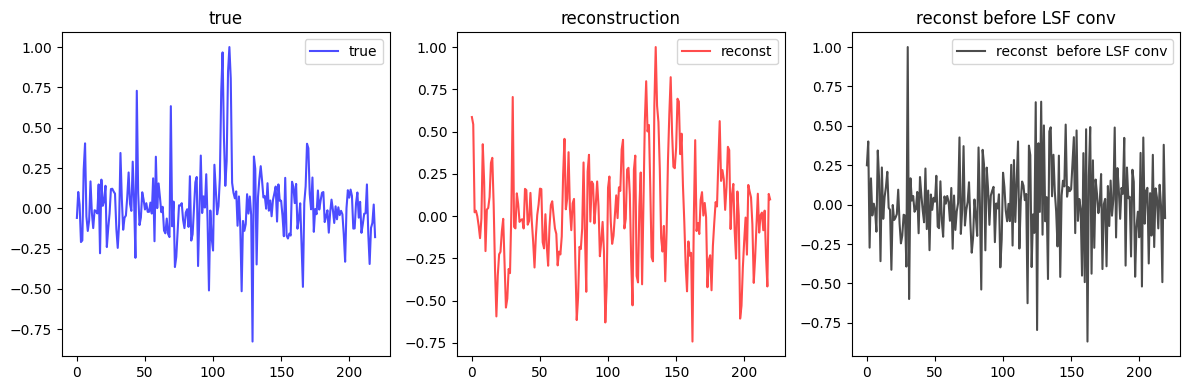

In [ ]:
import matplotlib.pyplot as plt

i=3
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

plt.plot()
# Plot the first graph on the first subplot
ax1.plot(batch['line'][i][0], color='blue',alpha=0.7, label='true')
#ax1.plot(rand[i][0].cpu().detach(), color='blue',alpha=0.7, label='true')
ax1.set_title('true')
ax1.set_ylabel('')
ax1.legend()

# Plot the second graph on the second subplot
ax2.plot(recon[i][0].cpu().detach()/torch.max(recon[i][0].cpu().detach()), color='red',alpha =0.7 , label='reconst')
ax2.set_title('reconstruction')
ax2.legend()

ax3.plot(x[i].cpu().detach()/torch.max(x[i].cpu().detach()), color='black',alpha =0.7 , label='reconst  before LSF conv')
ax3.set_title('reconst before LSF conv')
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
muse = instrument(device = device)
#x = torch.randn(5,1,220)
#muse.lsf(x,lbdas)*
#muse.gaussian_blur( mid_lbdas = lbdas)
#y = muse.lsf(x,torch.tensor([3400,3500,5090,7000,9100]) )

In [ ]:
torch.save(model1.state_dict(), 'aencoder2_weights.pth')

In [ ]:
import torch.nn.functional as F
import torch

class instrument:

  def __init__(self, device):
    self.device = device

  def gaussian_blur(self, mid_lbdas):
    """ Gaussian blur filter,
    Paramter: mid_lbda --> central wavelengths of the batch lines
    """
    # FWHM --> sigma
    def sigma_filter (lbda):
      return (5.866e-8 * lbda**2 - 9.187e-4 * lbda + 6.040)/(2.355*1.25) # in number of pixels

    s = sigma_filter(mid_lbdas) # in number of pixels
    sprime= s/0.3 + 1
    c = [int(si) for si in sprime]
    k_size = 2 * torch.tensor(c) + 1
    deltas = [torch.arange(k) for k in k_size]

    X = [torch.meshgrid(delta, indexing="ij") for delta in deltas]
    X_cent  = [x[0] - ci for x,ci in zip(X,c)]
    filters = [(x.to(device) / s).pow(2) for x,s in zip(X_cent, s)]
    filters = [torch.exp(-filt / 2.0) for filt in filters]
    filters = [filt / filt.flatten().sum() for filt in filters]
    return [filt.unsqueeze(dim=0).unsqueeze(dim=1) for filt in filters]

  def conv1d(self, x, filters):
    r"""
    Convolution of x and filter.
    :param x: (torch.Tensor) Line of size (B,C,W).
    :param filter: (torch.Tensor) Filter of size (1,C,W)
    :param padding: (string) options = 'valid','circular','replicate','reflect'. If padding='valid' the blurred output is smaller than the image (no padding), otherwise the blurred output has the same size as the image.
    """
    outputs = []

    # Perform 1D convolution for each batch element
    for i in range(len(filters)):

      output_i = F.conv1d(x[i:i+1].float(), filters[i].float(), padding='same')
      outputs.append(output_i)
    output = torch.cat(outputs, dim=0)

    return output

  def lsf(self, x, mid_lbda):
    """ Blur operator, this forward operator performs: y = w*x
    :param torch.Tensor filter: Tensor of size (1, 1, W) or (1, C, W) containing the blur filter,
    :param str padding: options are ``'valid'``, ``'circular'``, ``'replicate'`` and ``'reflect'``. If ``padding='valid'`` the blurred output is smaller than the image (no padding)
        otherwise the blurred output has the same size as the image.
    :param str device: cpu or cuda.
    """
    filters = self.gaussian_blur(mid_lbda)
    return self.conv1d(x, filters)



In [ ]:
b

In [ ]:
# Assuming your input tensor is named input_tensor
import numpy as np
x = np.linspace(0,100,200)
def f(x):
  return x**2 +x +2

input_tensor = torch.tensor(f(x)).unsqueeze(dim=0)  # Assuming input tensor size is [batch_size, 220]

# Reshape input tensor to [batch_size, 1, 220] for 1D interpolation
input_tensor = input_tensor.unsqueeze(1)

# Define the desired output size
output_size = 170

# Use interpolate function for downsampling
output_tensor = F.interpolate(input_tensor, size=output_size, mode='linear', align_corners=False)

# Remove the extra dimension added for interpolation
output_tensor = output_tensor.squeeze(1)

print("Input tensor size:", input_tensor.size())
print("Output tensor size:", output_tensor.size())

Input tensor size: torch.Size([1, 1, 200])
Output tensor size: torch.Size([1, 170])


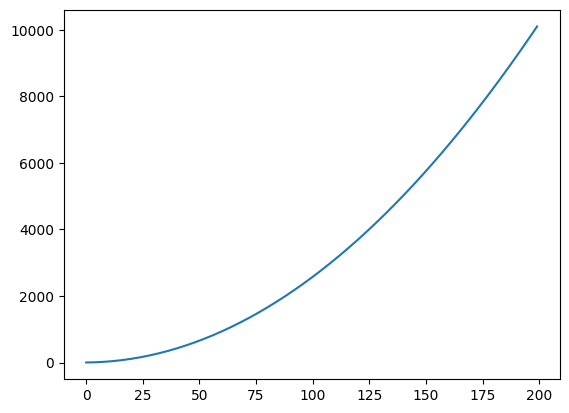

In [ ]:
plt.plot(input_tensor[0][0])

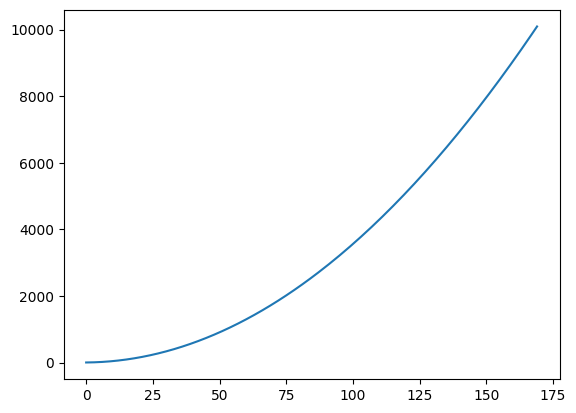

In [ ]:
plt.plot(output_tensor[0])